In [2]:
from keras.datasets import mnist
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.callbacks import Callback
from keras.models import model_from_json
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
#from keras.utils import multi_gpu_model
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import numpy as np
import argparse
import random
import cv2
import os
%matplotlib inline



config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
file_name = 'UNET_autoencoder_cityscape_100e_size128_color'
number_epochs = 70
batch_size = 16

tf.device("GPU:0")

Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


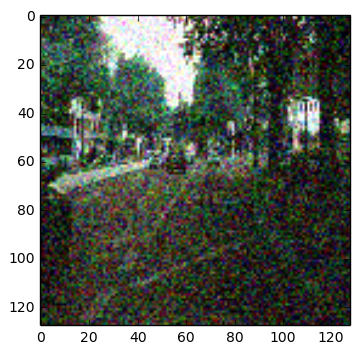

In [8]:
# Loading and shaping
x_train = np.reshape(x_train, (len(x_train), imsize, imsize,3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), imsize, imsize,3))  # adapt this if using `channels_first` image data format

# #Add noise and Darken the images
noise_factor = 1.5
x_train_noisy = (x_train) + noise_factor * np.random.normal(loc=0.0, scale=0.1, size=x_train.shape) 
x_test_noisy = (x_test) + noise_factor * np.random.normal(loc=0.0, scale=0.1, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Start commenting from here to test the model
plt.imshow(x_test_noisy[0].reshape(imsize,imsize,3))
plt.gray()
plt.show()



In [6]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization

'''
U-Net: Convolutional Networks for Biomedical Image Segmentation
(https://arxiv.org/abs/1505.04597)
---
img_shape: (height, width, channels)
out_ch: number of output channels
start_ch: number of channels of the first conv
depth: zero indexed depth of the U-structure
inc_rate: rate at which the conv channels will increase
activation: activation function after convolutions
dropout: amount of dropout in the contracting part
batchnorm: adds Batch Normalization if true
maxpool: use strided conv instead of maxpooling if false
upconv: use transposed conv instead of upsamping + conv if false
residual: add residual connections around each conv block if true
'''

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=3, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

Train on 1143 samples, validate on 382 samples
Epoch 1/70
1143/1143 [==============================] - 58s 51ms/step - loss: 0.7068 - val_loss: 0.5595

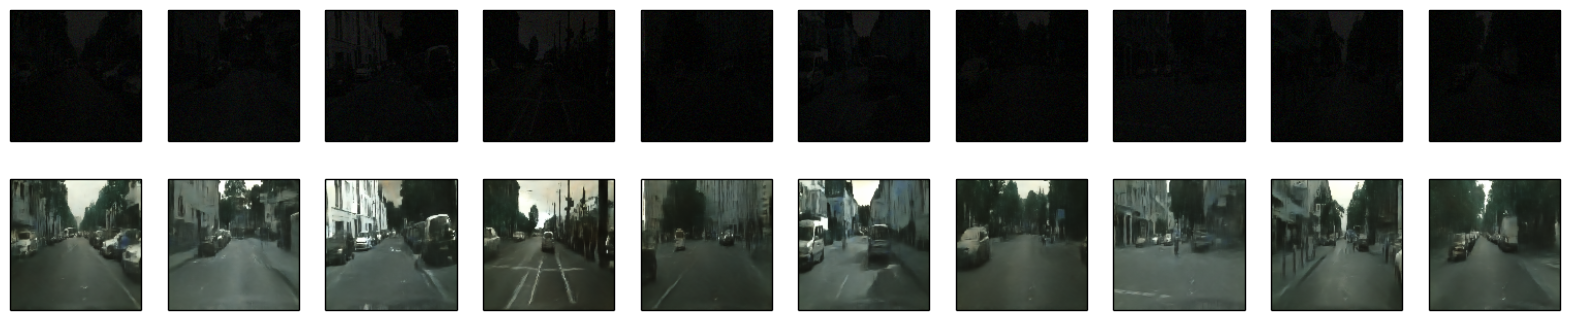

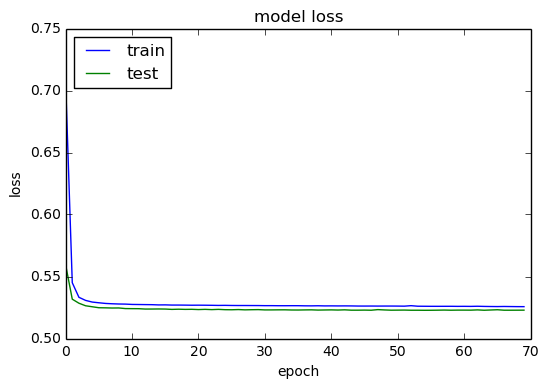

In [7]:

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Model = 
autoencoder = UNet((imsize, imsize, 3))
# autoencoder = Model(input_img, decoded)
#parallel_model = multi_gpu_model(autoencoder, gpus=2)
autoencoder.compile(loss='binary_crossentropy',
                       optimizer='adam')

histories = LossHistory()

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=1,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(x_train_noisy, x_train,
                epochs=number_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[checkpointer, tensorboard, histories]).history
logs = open((file_name + '.txt'),'w')
logs.write('The following is an array of values of the loss by epoch (hopefully) \n') 
logs.write(str(histories.losses))
logs.write('\nThe following are the different categories of losses measured by the model: \n')
logs.write(str(history.keys))
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test_noisy[i].reshape(imsize, imsize,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i].reshape(imsize, imsize,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(file_name + '_results.pdf')
plt.show()


plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig((file_name + 'loss_plot.pdf'))
plt.show()


# from keras.models import load_model
# serialize weights to HDF5
#autoencoder.save(file_name + '.h5')
#autoencoder.save_weights(file_name + '_weights.h5')
# serialize model to JSON
#model_json = autoencoder.to_json()
#with open(file_name + ".json", "w") as json_file:
 #   json_file.write(model_json)

# # Start uncommenting from here downwards for testing
# #load json and create model
# json_file = open(file_name + '.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights(file_name + "_weights.h5")
# print("Loaded model from disk")
# #evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(x_test_noisy, x_test, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


In [ ]:

x_test_noisy[0]*100
